# Detection of Bruxism events in Tinnitus patients polysomnographic data
This notebook will 
- load EMG channels of polusomnographic data
- detect the EMG bursts in a unsupervised way
- classify EMG bursts as different bruxism events
- give insights on the bruxism events

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mne
import scipy
import seaborn as sns
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, Annotate
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from IPython.core.display import display
from ipywidgets import widgets
print("Config loaded")


Config loaded


## Load, filter, and prepare data

In [3]:
filename = Config.bruxisme_files[0]  # load file from config
picks_chan = ['1','2']           # subset of EMG electrodes

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
raw  = CreateRaw(raw[picks_chan][0], picks_chan, ch_types=['emg'])        # pick channels and load
raw  = raw.load_data()  # load data into memory 
print("Data loaded")
RAW  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=picks_chan)
ch_names = raw.info["ch_names"]
print("Data filtered")

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/1DA15_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Data loaded
Data filtered


<ipython-input-3-503c61323b25>:4: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


## Epoching data

In [4]:
sfreq = raw.info["sfreq"]
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape}")

Epochs done, shape (117720, 2, 50)


## Classifying epochs and annotate raw

In [5]:
# compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=2)
X        = rms(epochs)
labels   = pipeline.fit_predict(X)
print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length} seconds")

raw = CleanAnnotations(raw)
dict_annotations = {1: "Burst"}
raw = Annotate(RAW, labels, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")

bursts count: 2862/117720 (2.43%)
bursts time: 715.5 seconds
Raw annotated


## Display Annotations

In [21]:
%matplotlib qt
scalings = dict(emg=1e-4)
subraw = raw.copy().crop(tmin = 6 * 3600, tmax = 7 * 3600)
subraw.plot(scalings = scalings)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pandas as pd
li=raw["1"][:1000][0][0][1000000:1500000]
df = pd.DataFrame(li,columns=['signal'])


In [12]:
print(len(df)/(200*60))

41.666666666666664


## Affiche les distributions des epochs créés

[-2.00608217e-07  2.00213691e-05  1.06899945e-05  4.65605548e-06
  1.60173096e-06 -1.13411799e-06 -1.73620569e-06 -8.47286955e-07
 -3.01629494e-05  5.58652576e-06  3.75275509e-06  1.09694757e-05
 -1.44962914e-05  1.35149940e-05  1.64941971e-05  4.14249758e-06
  1.78125586e-06 -2.43640206e-05 -2.23338213e-05 -6.47753739e-06
  2.49730145e-05  1.72723958e-05 -4.38680676e-06 -9.03782708e-06
 -1.45529604e-05  2.63344024e-05 -3.10977345e-07 -8.61120387e-06
 -4.69193448e-06 -5.99840609e-06  3.41941148e-06 -6.18304609e-06
 -1.54529570e-08  4.04739442e-06  5.19351202e-06  1.44574300e-05
  2.69855826e-06 -1.43226199e-05 -2.32613199e-05  2.10252994e-05
  1.64684050e-06 -2.74610378e-05  1.82916934e-05  1.09970199e-05
  8.95224202e-07 -8.86698381e-06  9.96484303e-06 -6.10841812e-06
  7.44437757e-06 -3.02686238e-05  3.95818930e-06]


RuntimeError: Since bad epochs have not been dropped, the length of the Epochs is not known. Load the Epochs with preload=True, or call Epochs.drop_bad(). To find the number of events in the Epochs, use len(Epochs.events).

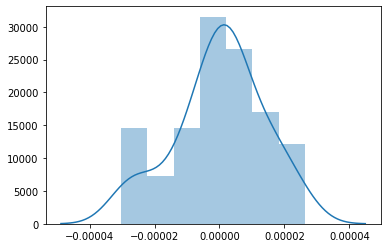

<Figure size 432x288 with 0 Axes>

In [14]:
print(epochs[0].get_data()[0][0])
plt.figure()
sns.distplot(Epo[0].get_data()[0][0])

plt.figure()
print(int(len(Epo)/100))
for i in range(int(len(Epo)/100)):
    sns.distplot(Epo[100*i].get_data()[0][0])

## Créé les transformées de Fourier (Welch) des epochs et récupère les coefficients entre 20 et 100 Hz

In [ ]:
#Epo.plot(scalings = 'auto', n_channels = 3)
def Extract_Alpha(E):
        AP = []
        print (len(E))
        flag = 0
        for epoch in E:

            #print len(epoch[0])

            #Il se passe des choses bizarres ici !! 

            FFTBIS = scipy.signal.welch(epoch, fs=200.0, window='hanning')
            if flag == 0 :
                print (len(epoch))
                print (FFTBIS[0][20:100])
                print (len(FFTBIS[0]))
                flag = 1
            ap = 0
            
            ap=FFTBIS[1][0][20:100]    #seulement la channel 1, de 20Hz à 50Hz
            
            AP.append(ap)


        return(AP)

get_al=Extract_Alpha(Epo)
print(get_al[:10])

## Affiche l'ensemble des FFTs précedemment calculées

In [ ]:
plt.figure()
print(int(len(get_al)/100))
for i in range(int(len(get_al)/100)):
    plt.plot(get_al[100*i])